Machine Learning Project

The purpose of this investigation is to use the exiting Enron Financial Data to build a classifier that can predict if an employee is a Person of Interest. The story of Enron needs no introduction from me and is a famous example of corporate malfeasance.


In [1]:
import sys
import pickle
import pandas
import numpy as np
sys.path.append("../tools/")



from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


C:\Users\James2SxyBoogaloo\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


SECTION 1: INITIAL DATA EXPLORATION

In [2]:
TotalFeatures = len(data_dict["SKILLING JEFFREY K"])
people = len(data_dict)
TotalObs = TotalFeatures*people

print("The number of features is:", str(TotalFeatures))
    
count = 0
for key, value in data_dict.iteritems():
	if data_dict[key]["poi"]==1:
		count += 1

print "The total number of PoI's in the initial dataset is {0} out of {1}:".format(count, people)
print("The total number of observations is:", str(TotalObs))
#are there any features with many missing values?
#for this it's easier to make the switch from a python dictionary to a dataframe
df = pandas.DataFrame.from_dict(list(data_dict.values()),dtype="float64")
employees = pandas.Series(list(data_dict.keys()))
df.set_index(employees, inplace=True)
print "Number of NaN's for each feature:"
df.isnull().sum()


('The number of features is:', '21')
The total number of PoI's in the initial dataset is 18 out of 146:
('The total number of observations is:', '3066')
Number of NaN's for each feature:


bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                  0
exercised_stock_options       44
expenses                      51
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       60
to_messages                   60
total_payments                21
total_stock_value             20
dtype: int64

DATA VISUALISATION SECTION

In [3]:
df.describe()
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299.0,29.0,38.0,1.0,...,NaN,1740.0,0.0,585062.0,NaN,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,NaN,NaN,6680544.0,11200.0,NaN,NaN,NaN,...,1586055.0,2660303.0,0.0,3942714.0,NaN,267102.0,NaN,NaN,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,NaN,-400729.0,NaN,steven.elliott@enron.com,4890344.0,78552.0,NaN,NaN,NaN,...,NaN,12961.0,0.0,1788391.0,NaN,170941.0,NaN,NaN,211725.0,6678735.0
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850.0,NaN,12.0,10.0,0.0,...,NaN,NaN,0.0,386335.0,NaN,NaN,58.0,764.0,NaN,1038185.0
HANNON KEVIN P,1500000.0,NaN,-3117011.0,NaN,kevin.hannon@enron.com,5538001.0,34039.0,32.0,32.0,21.0,...,1617011.0,11350.0,1.0,853064.0,NaN,243293.0,1035.0,1045.0,288682.0,6391065.0


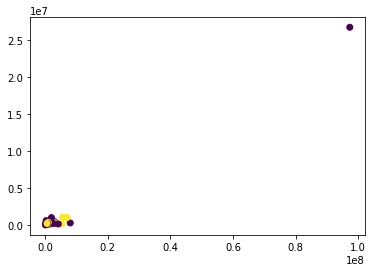

In [4]:
import matplotlib.pyplot as plt

x = df[["bonus"]]
y = df[["salary"]]
cpoi = df[["poi"]]

plt.scatter(x,y,c=cpoi)
plt.show()

Outlier removal - clearly there is an issue with one of the feautres. Let's find out what it is.

In [5]:
len(df.index)

146

In [6]:
df2 = df.sort_values(by='salary', ascending=0)
df2.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
TOTAL,97343619.0,32083396.0,-27992891.0,1398517.0,NaN,311764000.0,5235198.0,NaN,NaN,NaN,...,48521928.0,42667589.0,0.0,130322299.0,-7576788.0,26704229.0,NaN,NaN,309886585.0,434509511.0
SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,...,1920000.0,22122.0,1.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
LAY KENNETH L,7000000.0,202911.0,-300000.0,NaN,kenneth.lay@enron.com,34348384.0,99832.0,36.0,123.0,16.0,...,3600000.0,10359729.0,1.0,14761694.0,NaN,1072321.0,2411.0,4273.0,103559793.0,49110078.0
FREVERT MARK A,2000000.0,6426990.0,-3367011.0,NaN,mark.frevert@enron.com,10433518.0,86987.0,21.0,242.0,6.0,...,1617011.0,7427621.0,0.0,4188667.0,NaN,1060932.0,2979.0,3275.0,17252530.0,14622185.0
PICKERING MARK R,300000.0,NaN,NaN,NaN,mark.pickering@enron.com,28798.0,31653.0,67.0,7.0,0.0,...,NaN,NaN,0.0,NaN,NaN,655037.0,728.0,898.0,1386690.0,28798.0


In [7]:

ps = df2.count(axis=1)
ps.sort_values(ascending=True)

LOCKHART EUGENE E                 2
GRAMM WENDY L                     4
WODRASKA JOHN                     4
WHALEY DAVID A                    4
SCRIMSHAW MATTHEW                 4
THE TRAVEL AGENCY IN THE PARK     4
WROBEL BRUCE                      4
CHRISTODOULOU DIOMEDES            5
WAKEHAM JOHN                      5
CLINE KENNETH W                   5
SAVAGE FRANK                      5
GILLIS JOHN                       5
LOWRY CHARLES P                   6
YEAP SOON                         6
GATHMANN WILLIAM D                6
CHAN RONNIE                       6
FUGH JOHN L                       6
URQUHART JOHN A                   6
WINOKUR JR. HERBERT S             6
MENDELSOHN JOHN                   6
MEYER JEROME J                    6
BLAKE JR. NORMAN P                6
PEREIRA PAULO V. FERRAZ           6
LEMAISTRE CHARLES                 7
WALTERS GARETH W                  7
DUNCAN JOHN H                     7
PRENTICE JAMES                    7
GRAY RODNEY                 

In [8]:
df2.ix["LOCKHART EUGENE E"]

C:\Users\James2SxyBoogaloo\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


bonus                        NaN
deferral_payments            NaN
deferred_income              NaN
director_fees                NaN
email_address                NaN
exercised_stock_options      NaN
expenses                     NaN
from_messages                NaN
from_poi_to_this_person      NaN
from_this_person_to_poi      NaN
loan_advances                NaN
long_term_incentive          NaN
other                        NaN
poi                            0
restricted_stock             NaN
restricted_stock_deferred    NaN
salary                       NaN
shared_receipt_with_poi      NaN
to_messages                  NaN
total_payments               NaN
total_stock_value            NaN
Name: LOCKHART EUGENE E, dtype: object

Each person will have at least 2 values in this DF that are not NaNs - their own name, and PoI. This is borne out by the check on LOCKHART. Therefore Mr Lockhart can be dropped from the data, and we need to think about what to do with 
the other employees that don't have much information.

Although there are multiple employees with few datapoints, due to the small size of the dataset we want to avoid
throwing out data unless we have good cause. Therefore I will not impose an arbitrary limit, on the minimum data points required to be included.  However this could be a good approach in different circumestances. We also know that Zero maps to NaN in this context. It is very possible that we could inadvertently deprive our algorithms of useful information, so if any points are to be excluded there must be a concrete reason for doing so. 



In [9]:
df2.ix["THE TRAVEL AGENCY IN THE PARK"]

bonus                           NaN
deferral_payments               NaN
deferred_income                 NaN
director_fees                   NaN
email_address                   NaN
exercised_stock_options         NaN
expenses                        NaN
from_messages                   NaN
from_poi_to_this_person         NaN
from_this_person_to_poi         NaN
loan_advances                   NaN
long_term_incentive             NaN
other                        362096
poi                               0
restricted_stock                NaN
restricted_stock_deferred       NaN
salary                          NaN
shared_receipt_with_poi         NaN
to_messages                     NaN
total_payments               362096
total_stock_value               NaN
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object

In [10]:
df2 = df2.drop({"LOCKHART EUGENE E"})
df2 = df2.drop(["TOTAL"])
df2 = df2.drop(["THE TRAVEL AGENCY IN THE PARK"])
len(df2.index)

143

Clear EDA requires the removal of Total.

For good measure I threw out the Travel Agency entry as well, as this is clearly not an employee and bad data.

With those adjustments made, lets do some Data Exploration.

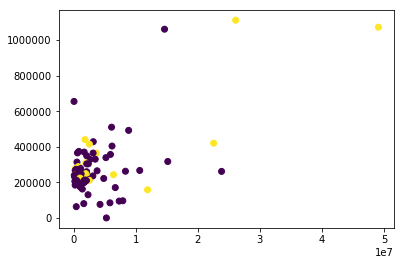

In [11]:
x = df2.total_stock_value
y = df2.salary
cpoi = df2.poi

plt.scatter(x,y,c=cpoi)

plt.show()

Potentially useful features - there are clear sections where no POI's appear. This will be useful information to our
algorithims.

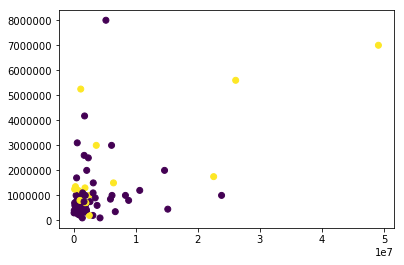

In [12]:
x = df2.total_stock_value
y = df2.bonus
cpoi = df2.poi

plt.scatter(x,y,c=cpoi)
plt.show()

Once again we can imagine our algorithim being able to make use of this information. There isn't an immediately obvious
correlation however.

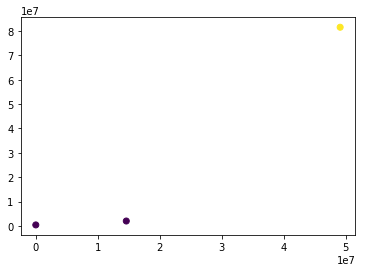

In [13]:
x = df2.total_stock_value
y = df2.loan_advances
cpoi = df2.poi

plt.scatter(x,y,c=cpoi)
plt.show()

Should have anticipated this result- loan advances only had 4 (non nan's) Non Zero Values in the data!'

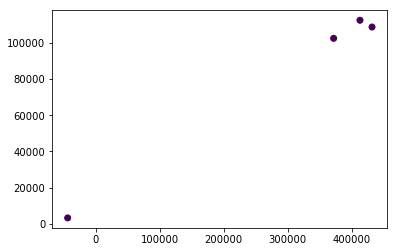

In [14]:
x = df2.total_stock_value
y = df2.director_fees
cpoi = df2.poi

plt.scatter(x,y,c=cpoi)
plt.show()

I am unable to explain this output however. There are 4 points on the graph, but the NaN's table showed that 20 people got director fees and 120 had a value for Total_stock_value. It seems odd that only 4 people would show up in both lists. Very confusing!

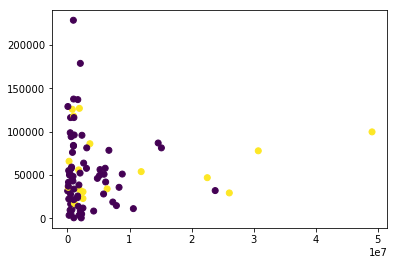

In [15]:
x = df2.total_stock_value
y = df2.expenses
cpoi = df2.poi

plt.scatter(x,y,c=cpoi)
plt.show()

Here we see that whilst no clear relationship is apparent, the data has a definite shape that perhaps an algorithim 
would be able to take advantage of. For example, nobody under a certain expenses threshold was a POI.

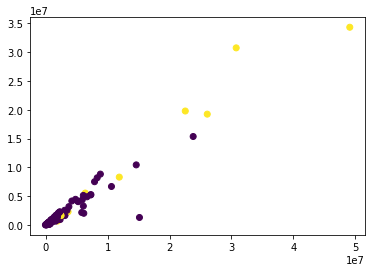

In [16]:
x = df2.total_stock_value
y = df2.exercised_stock_options
cpoi = df2.poi

plt.scatter(x,y,c=cpoi)
plt.show()

The data strongly suggests  a linear relationship between these two variables. If the correlation is too high it might make sense to drop one of them.

FEATURE SELECTION 

In [17]:
df2["Fromfract"] = df2.from_poi_to_this_person.divide(df2.from_messages, axis="index").fillna(0)
df2["Tofract"] = df2.from_this_person_to_poi.divide(df2.to_messages, axis="index").fillna(0)
df2["SaltoPay"] = df2.salary.divide(df2.total_payments, axis="index").fillna(0)
df2["ESVtoTSV"] = df2.exercised_stock_options.divide(df2.total_stock_value, axis="index").fillna(0)
df2["RStoTSV"] = df2.restricted_stock.divide(df2.total_stock_value, axis="index").fillna(0)


4. regarding features, its worth remembering that the irrelevant features will be dropped/merged as needed by SelectKbest and PCA. But as our last part of EDA lets see what the cross correlation is of our df as it stands.

In [18]:
df2.corr(method="pearson")

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,...,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,Fromfract,Tofract,SaltoPay,ESVtoTSV,RStoTSV
bonus,1.000000,0.293543,-0.411659,NaN,0.506998,0.033799,0.052725,0.562187,0.354634,0.973826,...,0.523190,0.549102,0.372997,0.569054,0.509441,0.083181,0.178842,-0.324554,0.183681,-0.143934
deferral_payments,0.293543,1.000000,-0.881500,NaN,0.019009,0.004800,0.321947,0.424101,0.206993,-1.000000,...,0.455884,0.356696,0.310129,0.066774,0.075710,0.570496,0.325110,-0.217174,0.143789,-0.030617
deferred_income,-0.411659,-0.881500,1.000000,-0.464837,-0.308076,0.101181,-0.319995,-0.178951,-0.271673,1.000000,...,-0.353816,-0.394677,-0.350815,-0.054404,-0.298189,-0.294988,-0.067138,-0.368901,-0.416388,0.148517
director_fees,NaN,NaN,-0.464837,1.000000,0.623257,-0.504631,1.000000,NaN,1.000000,NaN,...,NaN,1.000000,-1.000000,0.317360,0.997476,NaN,0.311606,NaN,0.242578,0.122766
exercised_stock_options,0.506998,0.019009,-0.308076,0.623257,1.000000,0.019412,-0.066129,0.160253,-0.030101,0.960259,...,0.607324,0.154333,0.079568,0.591690,0.963560,0.162210,-0.071531,0.138878,0.152256,-0.156944
expenses,0.033799,0.004800,0.101181,-0.504631,0.019412,1.000000,0.094144,-0.059244,0.014964,0.658681,...,0.145364,0.223495,0.155070,0.109798,0.034707,0.082202,-0.049390,-0.065014,-0.074790,0.151776
from_messages,0.052725,0.321947,-0.319995,1.000000,-0.066129,0.094144,1.000000,0.186708,0.588687,-0.213768,...,-0.003541,0.230855,0.475450,-0.033089,-0.036310,-0.165410,0.262992,0.015336,0.077577,-0.005982
from_poi_to_this_person,0.562187,0.424101,-0.178951,NaN,0.160253,-0.059244,0.186708,1.000000,0.445063,0.009878,...,0.179055,0.659264,0.525667,0.154431,0.146366,0.385918,0.087685,-0.010016,0.039395,0.106135
from_this_person_to_poi,0.354634,0.206993,-0.271673,1.000000,-0.030101,0.014964,0.588687,0.445063,1.000000,0.934835,...,0.021288,0.475748,0.568506,0.011556,0.001289,-0.162769,0.617118,-0.039627,0.006378,0.077239
loan_advances,0.973826,-1.000000,1.000000,NaN,0.960259,0.658681,-0.213768,0.009878,0.934835,1.000000,...,0.535252,0.291501,0.739805,0.991879,0.962026,-0.218806,0.880459,-0.598779,-0.550110,0.550110


In [19]:
#need to recreate the df to drop Nans
df2.fillna(0)
#create new features list
#features_list = df2.columns.values
#restructure so that poi is first column so the featureformat function works properly
#features_list.remove("poi")
#features_list.insert(0, "poi")

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,Fromfract,Tofract,SaltoPay,ESVtoTSV,RStoTSV
SKILLING JEFFREY K,5600000.0,0.0,0.0,0.0,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,...,1111258.0,2042.0,3627.0,8682716.0,26093672.0,0.814815,0.008271,0.127985,0.737727,0.262273
LAY KENNETH L,7000000.0,202911.0,-300000.0,0.0,kenneth.lay@enron.com,34348384.0,99832.0,36.0,123.0,16.0,...,1072321.0,2411.0,4273.0,103559793.0,49110078.0,3.416667,0.003744,0.010355,0.699416,0.300584
FREVERT MARK A,2000000.0,6426990.0,-3367011.0,0.0,mark.frevert@enron.com,10433518.0,86987.0,21.0,242.0,6.0,...,1060932.0,2979.0,3275.0,17252530.0,14622185.0,11.523810,0.001832,0.061494,0.713540,0.286460
PICKERING MARK R,300000.0,0.0,0.0,0.0,mark.pickering@enron.com,28798.0,31653.0,67.0,7.0,0.0,...,655037.0,728.0,898.0,1386690.0,28798.0,0.104478,0.000000,0.472375,1.000000,0.000000
WHALLEY LAWRENCE G,3000000.0,0.0,0.0,0.0,greg.whalley@enron.com,3282960.0,57838.0,556.0,186.0,24.0,...,510364.0,3920.0,6019.0,4677574.0,6079137.0,0.334532,0.003987,0.109109,0.540037,0.459963
DERRICK JR. JAMES V,800000.0,0.0,-1284000.0,0.0,james.derrick@enron.com,8831913.0,51124.0,909.0,64.0,20.0,...,492375.0,1401.0,2181.0,550981.0,8831913.0,0.070407,0.009170,0.893633,1.000000,0.202377
FASTOW ANDREW S,1300000.0,0.0,-1386055.0,0.0,andrew.fastow@enron.com,0.0,55921.0,0.0,0.0,0.0,...,440698.0,0.0,0.0,2424083.0,1794412.0,0.000000,0.000000,0.181800,0.000000,1.000000
SHERRIFF JOHN R,1500000.0,0.0,0.0,0.0,john.sherriff@enron.com,1835558.0,0.0,92.0,28.0,23.0,...,428780.0,2103.0,3187.0,4335388.0,3128982.0,0.304348,0.007217,0.098902,0.586631,0.413369
RICE KENNETH D,1750000.0,0.0,-3504386.0,0.0,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,...,420636.0,864.0,905.0,505050.0,22542539.0,2.333333,0.004420,0.832860,0.878081,0.121919
CAUSEY RICHARD A,1000000.0,0.0,-235000.0,0.0,richard.causey@enron.com,0.0,30674.0,49.0,58.0,12.0,...,415189.0,1585.0,1892.0,1868758.0,2502063.0,1.183673,0.006342,0.222174,0.000000,1.000000


In [20]:
#conver float nan to string NaN, otherwise the featureformat function won't deal with it.
df2 = df2.replace(np.nan, "NaN", regex=True)

# create a dictionary from the dataframe
data_dict = df2.to_dict('index')

my_dataset = data_dict

features_list = ['poi','salary', 'bonus', 'expenses', "total_payments", "exercised_stock_options",
"restricted_stock", "long_term_incentive", "deferral_payments", "deferred_income", "director_fees",
"other", "shared_receipt_with_poi", "total_payments", "total_stock_value", "Fromfract", "Tofract",
"SaltoPay", "ESVtoTSV", "RStoTSV"]


### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)



In [21]:
#imports
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn import feature_selection
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from pprint import pprint
import timeit
import numpy as np



In [22]:
#feature importances overview was not possible
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)


In [23]:
clf = GaussianNB().fit(X_train, y_train)
clf.score(X_test, y_test)

0.90697674418604646

In [24]:
clf = SVC().fit(X_train, y_train)
clf.score(X_test, y_test)



0.88372093023255816

In [25]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)

0.81395348837209303

In [26]:
clf = RandomForestClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)

0.90697674418604646

Initial results are promising!


However, unfortunately, as mentioned by Myles on the forum, the incidence of PoI's in our dataset is 13%. put another way, it would be possible for an algorithim that simply returned NOT A PoI for every single point to achieve an accuracy score of 87%! This means that we should be using recall and precision scores to assess performance instead. For simplicity this will be abbreviated to F1 score (this can be embedded into gridsearch) and then expanded later to recall and precision prior to submission.

In [27]:
#Feature Selection Test:Which is better- existing or new featureset? tested on decisiontree with default parameters

#create default traintestsplit, featurelist, datadict
default_features_list = ['poi','salary', 'bonus', 'expenses', "total_payments", "exercised_stock_options",
"restricted_stock", "long_term_incentive", "deferral_payments", "deferred_income", "director_fees",
"other", "shared_receipt_with_poi", "total_payments", "total_stock_value"]
default_data =featureFormat(my_dataset, default_features_list, sort_keys = True)
dlabels, dfeatures = targetFeatureSplit(default_data)
dX_train, dX_test, dy_train, dy_test = train_test_split(dfeatures, dlabels, test_size=0.3, random_state=42)


In [28]:
#create scaler
MMSs = MMS()
#Create Transformers
SKBt = SelectKBest()
PCAt = PCA(random_state=42)
FUt = FeatureUnion([("kbest", SKBt), ("pca", PCAt)])
#Create Classifiers
GNBc = GaussianNB()
SVCc = SVC(kernel="linear", random_state=42)
DTCc = DecisionTreeClassifier(random_state=42)
RFc = RandomForestClassifier(random_state=42)

In [29]:
#Investigate most important features using SSS to ensure robust importance results.
#Compare the results for both the default feature list and the feature list I created with my new ratios.
#repurposed some of the code from tester.py 
from sklearn.cross_validation import StratifiedShuffleSplit

#Cross validate and access Feature Importances on decisiontreeclassifier with 100 folds
clf = DecisionTreeClassifier(random_state=42)

cv = StratifiedShuffleSplit(labels, 100, random_state = 42)

FeatureValue = np.zeros(len(features_list)-1)
featrscore = np.zeros(len(features_list)-1)
featpscore = np.zeros(len(features_list)-1)

for train_idx, test_idx in cv: 
    features_train = []
    features_test  = []
    labels_train   = []
    labels_test    = []
    for ii in train_idx:
        features_train.append( features[ii] )
        labels_train.append( labels[ii] )
    for jj in test_idx:
        features_test.append( features[jj] )
        labels_test.append( labels[jj] )

    fit1 = clf.fit(features_train, labels_train)
        #add values to list
    FeatureValue += fit1.feature_importances_  
    pred = clf.predict(features_test)
    featrscore += recall_score(pred, labels_test)  
    featpscore += precision_score(pred, labels_test)
        
clf2 = DecisionTreeClassifier(random_state=42)       


FeatureValueDefault = np.zeros(len(default_features_list)-1)
featrscored = np.zeros(len(features_list)-1)
featpscored = np.zeros(len(features_list)-1)


for train_idx, test_idx in cv: 
    dfeatures_train = []
    dfeatures_test  = []
    dlabels_train   = []
    dlabels_test    = []
    for ii in train_idx:
        dfeatures_train.append( dfeatures[ii] )
        dlabels_train.append( dlabels[ii] )
    for jj in test_idx:
        dfeatures_test.append( dfeatures[jj] )
        dlabels_test.append( dlabels[jj] )

    fit2 = clf2.fit(dfeatures_train, dlabels_train)
 
    FeatureValueDefault += fit2.feature_importances_
    pred2 = clf2.predict(dfeatures_test)
    featrscored += recall_score(pred2, dlabels_test)  
    featpscored += precision_score(pred2, dlabels_test)
    
    
    
#average over the 100 folds
FeatureValue = FeatureValue/100
featrscore = featrscore/100
featpscore = featpscore/100

FeatureValueDefault = FeatureValueDefault/100
featrscored = featrscored/100
featpscored = featpscored/100


print "New Featureset:"
print "{} Recall & {} Precision".format(featrscore[1], featpscore[1])


print "Old Featureset:"
print "{} Recall & {} Precision".format(featrscored[1], featpscored[1])

ranks1 = np.argsort(FeatureValue)[::-1]
print "All features for Updated Featurelist"
for n in range(len(features_list)-1):
    print "{} feature: {} ({})".format(n, features_list[n+1], FeatureValue[ranks1[n]])

    ranks2 = np.argsort(FeatureValueDefault)[::-1]
print "All features for Default Featurelist"
for n in range(len(default_features_list)-1):
    print "{} feature: {} ({})".format(n, default_features_list[n+1], FeatureValueDefault[ranks2[n]])  

       



C:\Users\James2SxyBoogaloo\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


New Featureset:
0.2525 Recall & 0.26 Precision
Old Featureset:
0.2075 Recall & 0.22 Precision
All features for Updated Featurelist
0 feature: salary (0.15157943172)
1 feature: bonus (0.132620172679)
2 feature: expenses (0.107681830387)
3 feature: total_payments (0.086944516033)
4 feature: exercised_stock_options (0.0850770882743)
5 feature: restricted_stock (0.0768341892247)
6 feature: long_term_incentive (0.0578261679248)
7 feature: deferral_payments (0.0528884929341)
8 feature: deferred_income (0.0491795048977)
9 feature: director_fees (0.0465893504185)
10 feature: other (0.032468398451)
11 feature: shared_receipt_with_poi (0.027776646776)
12 feature: total_payments (0.0264091310324)
13 feature: total_stock_value (0.0198253318306)
14 feature: Fromfract (0.0197769107643)
15 feature: Tofract (0.0134790405578)
16 feature: SaltoPay (0.00990093895183)
17 feature: ESVtoTSV (0.00314285714286)
18 feature: RStoTSV (0.0)
All features for Default Featurelist
0 feature: salary (0.175544188366)
1

In [30]:
pred = fit1.predict(X_test)
pred2 = fit2.predict(dX_test)

acc = f1_score(pred, y_test)
acc2 = f1_score(pred2, dy_test)

print" F1 score based on added features:"
print(acc)
print"F1 score with just the default features:"
print(acc2)

 F1 score based on added features:
0.909090909091
F1 score with just the default features:
1.0


These results are confusing - if we are getting perfect accuracy there is no need to do any tuning!

In [31]:
#create scaler
MMSs = MMS()
#Create Transformers
SKBt = SelectKBest()
PCAt = PCA(random_state=42)
FUt = FeatureUnion([("kbest", SKBt), ("pca", PCAt)])
#Create Classifiers
GNBc = GaussianNB()
SVCc = SVC(kernel="linear", random_state=42)
DTCc = DecisionTreeClassifier(random_state=42)
RFc = RandomForestClassifier(random_state=42)
          

Commentary on methodology.

1. Scaler will be minmax scaler throughout, for each step. This is because there are so many values that are of different orders of magnitude, this will not interact well with some of the algorithims. For the same reason, this will precede feature selection. This will not change.
2. I will begin by trying to work out the best Feature Selection Method for each algorithim I will use. This means that in the initial run, all algorithim parameters will be set to their defaults.
3. I will do this by trying out SKB, PCA and FU for each classifier. This will include using both on their own.

A = SKB only
B = PCA only
C = SKB then PCA
D = PCA then SKB
E = FeatureUnion

1 = Gauss
2 = SVC
3 = DTC
4 = RFC

(all without parameters)



In [32]:
#GaussianNB featuresel Tests
estpipe1A = [("MMSs", MMSs), ("SKBt", SKBt), ("GNBc", GNBc)]
pipe1A = Pipeline(estpipe1A)
estpipe1B = [("MMSs", MMSs), ("PCAt", PCAt), ("GNBc", GNBc)]
pipe1B = Pipeline(estpipe1B)
estpipe1C = [("MMSs", MMSs), ("SKBt", SKBt), ("PCAt", PCAt), ("GNBc", GNBc)]
pipe1C = Pipeline(estpipe1C)
estpipe1D = [("MMSs", MMSs), ("PCAt", PCAt), ("SKBt", SKBt), ("GNBc", GNBc)]
pipe1D = Pipeline(estpipe1D)
estpipe1E = [("MMSs", MMSs), ("FUt", FUt), ("GNBc", GNBc)]
pipe1E = Pipeline(estpipe1E)


In [33]:
#SVC Scaler featuresel tests
estpipe2A = [("MMSs", MMSs), ("SKBt", SKBt), ("SVCc", SVCc)]
pipe2A = Pipeline(estpipe2A)
estpipe2B = [("MMSs", MMSs), ("PCAt", PCAt), ("SVCc", SVCc)]
pipe2B = Pipeline(estpipe2B)
estpipe2C = [("MMSs", MMSs), ("SKBt", SKBt), ("PCAt", PCAt), ("SVCc", SVCc)]
pipe2C = Pipeline(estpipe2C)
estpipe2D = [("MMSs", MMSs), ("PCAt", PCAt), ("SKBt", SKBt), ("SVCc", SVCc)]
pipe2D = Pipeline(estpipe2D)
estpipe2E = [("MMSs", MMSs), ("FUt", FUt), ("SVCc", SVCc)]
pipe2E = Pipeline(estpipe2E)


In [34]:
#DecisionTree featursel tests
estpipe3A = [("MMSs", MMSs), ("SKBt", SKBt), ("DTCc", DTCc)]
pipe3A = Pipeline(estpipe3A)
estpipe3B = [("MMSs", MMSs), ("PCAt", PCAt), ("DTCc", DTCc)]
pipe3B = Pipeline(estpipe3B)
estpipe3C = [("MMSs", MMSs), ("SKBt", SKBt), ("PCAt", PCAt), ("DTCc", DTCc)]
pipe3C = Pipeline(estpipe3C)
estpipe3D = [("MMSs", MMSs), ("PCAt", PCAt), ("SKBt", SKBt), ("DTCc", DTCc)]
pipe3D = Pipeline(estpipe3D)
estpipe3E = [("MMSs", MMSs), ("FUt", FUt), ("DTCc", DTCc)]
pipe3E = Pipeline(estpipe3E)


In [35]:
#RFC featuresel tests
estpipe4A = [("MMSs", MMSs), ("SKBt", SKBt), ("RFc", RFc)]
pipe4A = Pipeline(estpipe4A)
estpipe4B = [("MMSs", MMSs), ("PCAt", PCAt), ("RFc", RFc)]
pipe4B = Pipeline(estpipe4B)
estpipe4C = [("MMSs", MMSs), ("SKBt", SKBt), ("PCAt", PCAt), ("RFc", RFc)]
pipe4C = Pipeline(estpipe4C)
estpipe4D = [("MMSs", MMSs), ("PCAt", PCAt), ("SKBt", SKBt), ("RFc", RFc)]
pipe4D = Pipeline(estpipe4D)
estpipe4E = [("MMSs", MMSs), ("FUt", FUt), ("RFc", RFc)]
pipe4E = Pipeline(estpipe4E)


In [36]:
estimatorsA = [estpipe1A, estpipe2A, estpipe3A, estpipe4A]
pipesA = [pipe1A, pipe2A, pipe3A, pipe4A]
estimatorsB = [estpipe1B, estpipe2B, estpipe3B, estpipe4B]
pipesB = [pipe1B, pipe2B, pipe3B, pipe4B]
estimatorsC = [estpipe1C, estpipe2C, estpipe3C, estpipe4C]
pipesC = [pipe1C, pipe2C, pipe3C, pipe4C]
estimatorsD = [estpipe1D, estpipe2D, estpipe3D, estpipe4D]
pipesD = [pipe1D, pipe2D, pipe3D, pipe4D]
estimatorsE = [estpipe1E, estpipe2E, estpipe3E, estpipe4E]
pipesE = [pipe1E, pipe2E, pipe3E, pipe4E]


algos = ["GNB", "SVC", "DTC", "RF"]

In [37]:
print "SKB only results across Algorithims"
cnt= 0
scorelist = []
for estimator, pipe in zip(estimatorsA, pipesA):
    clf = pipe.fit(X_train, y_train)
    pred = clf.predict(X_test)
    recall = recall_score(pred, y_test)
    precision = precision_score(pred, y_test)
    f1 = f1_score(pred, y_test)
    print(algos[cnt], "Recall:", recall, "Precision:", precision, "F1", f1)
    cnt+=1
    
scorelist.append(f1)
comparator = (sum(scorelist)/4)

print "f1 average for comparison:", comparator

SKB only results across Algorithims
('GNB', 'Recall:', 0.40000000000000002, 'Precision:', 0.40000000000000002, 'F1', 0.40000000000000008)
('SVC', 'Recall:', 0.0, 'Precision:', 0.0, 'F1', 0.0)
('DTC', 'Recall:', 0.20000000000000001, 'Precision:', 0.20000000000000001, 'F1', 0.20000000000000004)
('RF', 'Recall:', 1.0, 'Precision:', 0.20000000000000001, 'F1', 0.33333333333333337)
f1 average for comparison: 0.0833333333333


C:\Users\James2SxyBoogaloo\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [38]:
print "PCA only results across Algorithims"
cnt = 0
scorelist = []
for estimator, pipe in zip(estimatorsB, pipesB):
    clf = pipe.fit(X_train, y_train)
    pred = clf.predict(X_test)
    recall = recall_score(pred, y_test)
    precision = precision_score(pred, y_test)
    f1 = f1_score(pred, y_test)
    print(algos[cnt], "Recall:", recall, "Precision:", precision, "F1", f1)
    cnt+=1
    
scorelist.append(f1)
comparator = (sum(scorelist)/4)

print "f1 average for comparison:", comparator

PCA only results across Algorithims
('GNB', 'Recall:', 0.2857142857142857, 'Precision:', 0.40000000000000002, 'F1', 0.33333333333333331)
('SVC', 'Recall:', 0.0, 'Precision:', 0.0, 'F1', 0.0)
('DTC', 'Recall:', 0.33333333333333331, 'Precision:', 0.59999999999999998, 'F1', 0.42857142857142855)
('RF', 'Recall:', 1.0, 'Precision:', 0.20000000000000001, 'F1', 0.33333333333333337)
f1 average for comparison: 0.0833333333333


In [39]:
print "C = SKB then PCA"
cnt = 0
scorelist = []
for estimator, pipe in zip(estimatorsC, pipesC):
    clf = pipe.fit(X_train, y_train)
    pred = clf.predict(X_test)
    recall = recall_score(pred, y_test)
    precision = precision_score(pred, y_test)
    f1 = f1_score(pred, y_test)
    print(algos[cnt], "Recall:", recall, "Precision:", precision, "F1", f1)
    cnt+=1

scorelist.append(f1)
comparator = (sum(scorelist)/4)

print "f1 average for comparison:", comparator

C = SKB then PCA
('GNB', 'Recall:', 0.59999999999999998, 'Precision:', 0.59999999999999998, 'F1', 0.59999999999999998)
('SVC', 'Recall:', 0.0, 'Precision:', 0.0, 'F1', 0.0)
('DTC', 'Recall:', 0.33333333333333331, 'Precision:', 0.40000000000000002, 'F1', 0.36363636363636359)
('RF', 'Recall:', 0.33333333333333331, 'Precision:', 0.20000000000000001, 'F1', 0.25)
f1 average for comparison: 0.0625


In [40]:
print "D = PCA then SKB"
cnt = 0
scorelist = []
for estimator, pipe in zip(estimatorsD, pipesD):
    clf = pipe.fit(X_train, y_train)
    pred = clf.predict(X_test)
    recall = recall_score(pred, y_test)
    precision = precision_score(pred, y_test)
    f1 = f1_score(pred, y_test)
    print(algos[cnt], "Recall:", recall, "Precision:", precision, "F1", f1)
    cnt+=1

scorelist.append(f1)
comparator = (sum(scorelist)/4)

print "f1 average for comparison:", comparator

D = PCA then SKB
('GNB', 'Recall:', 0.5, 'Precision:', 0.40000000000000002, 'F1', 0.44444444444444448)
('SVC', 'Recall:', 0.0, 'Precision:', 0.0, 'F1', 0.0)
('DTC', 'Recall:', 0.40000000000000002, 'Precision:', 0.40000000000000002, 'F1', 0.40000000000000008)
('RF', 'Recall:', 1.0, 'Precision:', 0.20000000000000001, 'F1', 0.33333333333333337)
f1 average for comparison: 0.0833333333333


In [41]:
print"E = FeatureUnion"
cnt = 0
scorelist = []
for estimator, pipe in zip(estimatorsE, pipesE):
    clf = pipe.fit(X_train, y_train)
    pred = clf.predict(X_test)
    recall = recall_score(pred, y_test)
    precision = precision_score(pred, y_test)
    f1 = f1_score(pred, y_test)
    print(algos[cnt], "Recall:", recall, "Precision:", precision, "F1", f1)
    cnt+=1
    scorelist.append(f1)
comparator = (sum(scorelist)/4)

print "f1 average for comparison:", comparator
   

E = FeatureUnion
('GNB', 'Recall:', 0.40000000000000002, 'Precision:', 0.40000000000000002, 'F1', 0.40000000000000008)
('SVC', 'Recall:', 0.5, 'Precision:', 0.20000000000000001, 'F1', 0.28571428571428575)
('DTC', 'Recall:', 0.375, 'Precision:', 0.59999999999999998, 'F1', 0.46153846153846151)
('RF', 'Recall:', 0.33333333333333331, 'Precision:', 0.20000000000000001, 'F1', 0.25)
f1 average for comparison: 0.349313186813


The primary thing here appears to be that, on average across the four chosen algorithims, using a train_test_split and MinMax Scaling, and default parameters, the FeatureUnion approach is the most accurate. By outputting each of the scores, this gives us a further starting point for subsequent investigation - RF in particular seems to get perfect recall for the PCA and PCA followed by SKB approach. So whilst the immediate intention is to focus on the Feature Union approach due to its consistency, we might circle back on the RF/PCA combination later.

Whilst the purpose of this step was to decide on the best featureselection parameters going forward, it would be remiss not to remark on how the GNB classifier has performed - it's actually exceeded the R/P requirements of the project in for each slection method other than PCA / Recall. This doesn't mean it will prove to be the most effective algorithim overall, however it does validate my decision to show the outputs.

So we've found Feature Union Generalises best on average.

OK so after doing that we have our optimum featsel parameters for each algo:
    
    
    Gauss: PCA 9  SKB 5
    SVC: PCA1 SKB 6
    DTREE: PCA 14 SKB 1
    Rforest: PCA 2 SKB 9



In [42]:
#runner document

#create featureunion object
combined = FeatureUnion([("pca", PCAt), ("skb", SKBt)])

#create pipelines, one for each object. Note MMS included.
Pipe = Pipeline([("MMS", MMSs),
                ("combined", combined),
                 ("clf", GNBc)])

Pipe2 = Pipeline([("MMS", MMSs),
                ("combined", combined),
                 ("clf", SVCc)])

Pipe3 = Pipeline([("MMS", MMSs),
                ("combined", combined),
                 ("clf", DTCc)])

Pipe4 = Pipeline([("MMS", MMSs),
                ("combined", combined),
                 ("clf", RFc)])

#Gauss
prm_grid = dict(combined__pca__n_components=[9],
               combined__skb__k=[5])
#SVC
prm_grid2 = dict(combined__pca__n_components=[1],
               combined__skb__k=[6],
                clf__C = [1.2],
               clf__kernel = ["linear"],
                clf__class_weight = ["balanced", None])
#Dtree
prm_grid3 = dict(combined__pca__n_components=[6],
               combined__skb__k=[6],
                clf__criterion=["gini"],
                clf__max_features=["auto"],
                clf__max_depth = [9],
                clf__class_weight = ["balanced"],
                clf__min_samples_split = [6],
                clf__splitter = ["random"])

#Rforest
prm_grid4 = dict(combined__pca__n_components=[5],
               combined__skb__k=[5],
                clf__criterion=["gini"],
                clf__max_features=[None],
                clf__max_depth = [5],
                clf__class_weight = ["balanced"],
                clf__min_samples_split = [15],
                clf__n_estimators = [5]
                )    
    
cv_sss = StratifiedShuffleSplit(labels, 10, test_size=0.3, random_state=42)


#create a gridsearch object for each algorithim, using a different pipe
grid = GridSearchCV(Pipe, prm_grid, cv = cv_sss, scoring ="f1")
grid2 = GridSearchCV(Pipe2, prm_grid2, cv = cv_sss, scoring ="f1")
grid3 = GridSearchCV(Pipe3, prm_grid3, cv = cv_sss, scoring ="f1")
grid4 = GridSearchCV(Pipe4, prm_grid4, cv = cv_sss, scoring ="f1")



The cell above was ran and reran repeatedly to set up each iteration of the parameter grid. I have documented this
process in the Outputs Notebook, together with the results for each parameter run.

In [43]:
#GAUSS APPLICATIoN
start_time = timeit.default_timer()
grid.fit(features, labels)
print("Time Taken:  %r" % (timeit.default_timer() - start_time))
print "Best F1 Score:"
print(grid.best_score_)
print "Best parameters:"
best_parameters = grid.best_estimator_.get_params()
for param_name in sorted(prm_grid.keys()):
       print '\t%s: %r' % (param_name, best_parameters[param_name])


Time Taken:  0.16396773910105603
Best F1 Score:
0.3613997114
Best parameters:
	combined__pca__n_components: 9
	combined__skb__k: 5


In [44]:
#SVC TUNER
start_time = timeit.default_timer()
grid.fit(features, labels)
print("Time Taken:  %r" % (timeit.default_timer() - start_time))
#print "Best Estimator:"
#print(grid.best_estimator_)
print "Best F1 Score:"
print(grid.best_score_)
print "Best parameters:"
best_parameters = grid.best_estimator_.get_params()
for param_name in sorted(prm_grid.keys()):
       print '\t%s: %r' % (param_name, best_parameters[param_name])

Time Taken:  0.16062445160308253
Best F1 Score:
0.3613997114
Best parameters:
	combined__pca__n_components: 9
	combined__skb__k: 5


In [45]:
#DTREE tuner
start_time = timeit.default_timer()
grid3.fit(features, labels)
print("Time Taken:  %r" % (timeit.default_timer() - start_time))
#print "Best Estimator:"
#print(grid.best_estimator_)
print "Best F1 Score:"
print(grid3.best_score_)
print "Best parameters:"
best_parameters = grid3.best_estimator_.get_params()
for param_name in sorted(prm_grid3.keys()):
       print '\t%s: %r' % (param_name, best_parameters[param_name])

Time Taken:  0.19925727410997268
Best F1 Score:
0.41497665733
Best parameters:
	clf__class_weight: 'balanced'
	clf__criterion: 'gini'
	clf__max_depth: 9
	clf__max_features: 'auto'
	clf__min_samples_split: 6
	clf__splitter: 'random'
	combined__pca__n_components: 6
	combined__skb__k: 6


In [46]:
#Random Forest Classifer
start_time = timeit.default_timer()
grid4.fit(features, labels)
print("Time Taken:  %r" % (timeit.default_timer() - start_time))
#print "Best Estimator:"
#print(grid.best_estimator_)
print "Best F1 Score:"
print(grid4.best_score_)
print "Best parameters:"
best_parameters = grid4.best_estimator_.get_params()
for param_name in sorted(prm_grid4.keys()):
       print '\t%s: %r' % (param_name, best_parameters[param_name])

Time Taken:  0.43641101830733
Best F1 Score:
0.397475465711
Best parameters:
	clf__class_weight: 'balanced'
	clf__criterion: 'gini'
	clf__max_depth: 5
	clf__max_features: None
	clf__min_samples_split: 15
	clf__n_estimators: 5
	combined__pca__n_components: 5
	combined__skb__k: 5


RESULTS OF PARAMETER TUNING:

The parameter tuner that got the highest F1 score was
    
Decision Tree Classifier, with the following parameters:

Best parameters:
	clf__class_weight: 'balanced'
	clf__criterion: 'gini'
	clf__max_depth: 9
	clf__max_features: 'auto'
	clf__min_samples_split: 6
	clf__splitter: 'random'
	combined__pca__n_components: 6
	combined__skb__k: 6

In [47]:
clf = grid3.best_estimator_
#import test_classifier
from tester import test_classifier
print "Tester Classification Report"
test_classifier(clf, my_dataset, features_list)

Tester Classification Report
Pipeline(steps=[('MMS', MinMaxScaler(copy=True, feature_range=(0, 1))), ('combined', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=6, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('skb', SelectKBest(k=6, score_func=<function f_cla...it=6, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='random'))])
	Accuracy: 0.74373	Precision: 0.26002	Recall: 0.49950	F1: 0.34201	F2: 0.42180
	Total predictions: 15000	True positives:  999	False positives: 2843	False negatives: 1001	True negatives: 10157



Unfortunately, whilst recall is sufficient, we are let down by precision.

Let's try our RandomForest Classifier - whilst overall F1 score was lower, maybe recall was over 0.3?


In [48]:
clf = grid4.best_estimator_
#import test_classifier
from tester import test_classifier
print "Tester Classification Report"
test_classifier(clf, my_dataset, features_list)

Tester Classification Report
Pipeline(steps=[('MMS', MinMaxScaler(copy=True, feature_range=(0, 1))), ('combined', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('skb', SelectKBest(k=5, score_func=<function f_cla...estimators=5, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])
	Accuracy: 0.80767	Precision: 0.33358	Recall: 0.44350	F1: 0.38077	F2: 0.41608
	Total predictions: 15000	True positives:  887	False positives: 1772	False negatives: 1113	True negatives: 11228



After several days of second guessing, we have a winner!

Phew!

Conclusion and Discussion:

Feature selection and importances was handled by Gridsearch - I was unable to pick out the specifics of each feature used because of the decision to use FeatureUnion. I couldn't locate documentation showing the methods to use that would allow me to extract the feature importances / feature scores from a FeatureUnion Object.


As mentioned above, MinMaxScaler was chosen because of the wide variance in the dataset.

The rationale behind the features I created is basically that there might be information hidden in the ratios between certain features, rather than the features themselves.

I ended up using the RandomForest Classifier due to the fact it met the required Recall and Precision scores.

I tried the SVC, DecisionTree, Gaussian Naive Bayes and Random Forest algorithims. Gaussian Naive Bayes was the most accurate and wouldn't have required any tuning to meet requirements, according to the preliminary test (f1 score). The test I added just below this text box actually confirms that this is more accurate for  precision, and sufficient (but lower) on recall than the RandomForest Classifier I spent several days tuning.

In this context, the importance of parameter tuning appears to be secondary to picking the best algorithim. However in the attached outputs notebook i have attempted to show the process I went through for SVC DTREE and RFOREST classifiers.

The primary aid in getting a good result appears to be setting up as wide a parameter search as possible for your initial run, leaving it overnight, and then iterating on that. Running on a more restriceted paramter space in 30 second increments means that you are having to guess about what adjustments to make, and it's a very trial and error approach. This was demonstrated by my decision to go back and tune PCA and SKB, despite initially intending to keep these values as a constant for each algorithim. Parameters were chosen by scanning SKLearn and picking ones that sounded relevant from the list.

Validation is the process of checking that your algorithim actually works. This can be done by manually splitting data into the training and test sets, but this leaves the problem of reducing your dataset. As our data is already unbalanced, this can cause performace problems as the classifier is trying to infer information about a very small subsample of the data as it is, without further reducing it. A classic mistake is to train and validate on the same data - this would only measure the bias of your classifer and tell you nothing about it's ability to make predicitions.

I validated my analysis by using GridsearchCV's built in CrossValidation StratifiedShuffleSplit method, where subsamples of test and training data are taken from the data a specified number of times, and the results averaged across each test. The stratified sampling approach ensures that each "fold" (test) contains roughly equal numbers of each class, in this case meaning that the number of PoIs showing up in each test will be more similar than if it was entirely random, thus helping the algorithim generalise.

Analysis of result:

This is the  output showing the performance of my chosen classifier

Accuracy: 0.80767	Precision: 0.33358	Recall: 0.44350	F1: 0.38077	F2: 0.41608
	Total predictions: 15000	True positives:  887	False positives: 1772	False negatives: 1113	True negatives: 11228

Accuracy - the most intuitive output metric. Defined technically as

(True positive plus True Negative) /  Total Predictions

or alternatively, out of every guess made by the classifier, what proportion was correct? How good is it at correctly determining if someone is a PoI or not?

For the reasons given above this is not a useful metric in this context.


Precision  = True positives / (True Positives + False Positives)

When the classifier identifies someone as a POI, how sure can we be that it is correct?

If this is high, we can be confident that anyone flagged as a PoI is actually a PoI.
If this is low, this means that we are flagging people as PoIs mistakenly.

In this case my precision score was 0.33 which means we are getting lots of false positives.

Recall = True Positives / ( True Positives + False Negatives)

If this is high, we are able to track down a large percentage of the actual PoIs in the data.
If this is low then we often miss real PoIs because the algo is overly cautious.

Recall was 0.44 which means that we were also missing real PoIs.

It is important to use the full range of validation metrics - if we only looked at accuracy, we would have an unduly high confidence about our ability to make predictions.  Recall and Precision are both independent of any imbalances in the dataset, unlike Accuracy.


In [49]:
#Gaussian N
clf = grid.best_estimator_
#import test_classifier
from tester import test_classifier
print "Tester Classification Report"
test_classifier(clf, my_dataset, features_list)

Tester Classification Report
Pipeline(steps=[('MMS', MinMaxScaler(copy=True, feature_range=(0, 1))), ('combined', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=9, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('skb', SelectKBest(k=5, score_func=<function f_classif at 0x000000000CE39F98>))],
       transformer_weights=None)), ('clf', GaussianNB(priors=None))])
	Accuracy: 0.84240	Precision: 0.40441	Recall: 0.38500	F1: 0.39447	F2: 0.38873
	Total predictions: 15000	True positives:  770	False positives: 1134	False negatives: 1230	True negatives: 11866



Final Test: How did the inclusion of my new features affect the performance of my final algorithim?
    
    
    
    
    

In [50]:
#Rforest
start_time = timeit.default_timer()
grid4.fit(dfeatures, dlabels)
print("Time Taken:  %r" % (timeit.default_timer() - start_time))
#print "Best Estimator:"
#print(grid.best_estimator_)
print "Best F1 Score:"
print(grid4.best_score_)
print "Best parameters:"
best_parameters = grid4.best_estimator_.get_params()
for param_name in sorted(prm_grid4.keys()):
       print '\t%s: %r' % (param_name, best_parameters[param_name])


clf = grid4.best_estimator_
#import test_classifier
from tester import test_classifier
print "Tester Classification Report"
test_classifier(clf, my_dataset, default_features_list)

Time Taken:  0.43426786149643704
Best F1 Score:
0.293097343833
Best parameters:
	clf__class_weight: 'balanced'
	clf__criterion: 'gini'
	clf__max_depth: 5
	clf__max_features: None
	clf__min_samples_split: 15
	clf__n_estimators: 5
	combined__pca__n_components: 5
	combined__skb__k: 5
Tester Classification Report
Pipeline(steps=[('MMS', MinMaxScaler(copy=True, feature_range=(0, 1))), ('combined', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('skb', SelectKBest(k=5, score_func=<function f_cla...estimators=5, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])
	Accuracy: 0.76573	Precision: 0.24391	Recall: 0.36050	F1: 0.29096	F2: 0.32904
	Total predictions: 15000	True positives:  721	False positives: 2235	False negatives: 1279	True negatives: 10765



#28/07/2017 RESUBMISSIoN - Output from Testing Notebook.